# NN implemetation with Pythorch

# Imports

In [55]:
import numpy as np
import pandas as pd
import torch.nn as nn
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Utils functions and classes

In [56]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): Numero di epoche da aspettare prima di interrompere l'allenamento
                            se non c'è miglioramento. Default: 5.
            delta (float): Miglioramento minimo richiesto per considerare un progresso. Default: 0.
            path (str): Percorso dove salvare il modello migliore. Default: 'checkpoint.pt'.
            verbose (bool): Stampa messaggi quando il modello migliora. Default: False.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: No improvement for {self.counter} epochs")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Salva il modello quando la perdita di validazione migliora."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [57]:
# Funzione per normalizzare i dati
def normalize(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data

In [58]:
def split_data(data, labels, k=5):
    """
    Divide i dati in k fold.
    
    Args:
        data (np.ndarray | pd.DataFrame): Dati di input.
        labels (np.ndarray | pd.Series): Etichette.
        k (int): Numero di fold.
    
    Returns:
        list: Lista di tuple (fold_data, fold_labels).
    """
    if not isinstance(data, np.ndarray):
        data = data.to_numpy()  # Converte DataFrame in NumPy array
    if not isinstance(labels, np.ndarray):
        labels = labels.to_numpy()  # Converte Series in NumPy array
    
    data = normalize(data)

    fold_size = len(data) // k
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    folds = []

    for i in range(k):
        fold_indices = indices[i * fold_size: (i + 1) * fold_size]
        fold_data = data[fold_indices]
        fold_labels = labels[fold_indices]
        folds.append((fold_data, fold_labels))
    
    return folds

In [59]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history, 
    adding the parameters as a title.

    Parameters:
    - history: History object returned by model.fit().
    - params: Dictionary containing the model parameters.
    """

    # Estrai dati dalla history
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_acc = history['train_mee']
    val_acc = history['val_mee']
    
    
    epochs = range(1, len(train_loss) + 1)  # Numero di epoche

    # Grafico della Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Grafico dell'Accuracy
    plt.subplot(1, 2, 2)
    if train_acc:
        plt.plot(epochs, train_acc, 'b-o', label='Training MEE')
    if val_acc:
        plt.plot(epochs, val_acc, 'r-o', label='Validation MEE')
    plt.title('Training and Validation MEE')
    plt.xlabel('Epochs')
    plt.ylabel('MEE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [60]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Genera tutte le combinazioni di iperparametri basate su range e step specificati.

    :param param_ranges: Dizionario con i nomi degli iperparametri come chiavi.
                         Ogni valore è una tupla (start, stop, step).
    :return: Lista di dizionari con tutte le combinazioni possibili.
    """
    param_values = {
        key: np.arange(start, stop + step, step)
        for key, (start, stop, step) in param_ranges.items()
    }
    
    param_combinations = list(itertools.product(*param_values.values()))
    return [
        dict(zip(param_values.keys(), combination))
        for combination in param_combinations
    ]

## Model creation, train and evaluation

In [61]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layers, alpha, activ_type = 'tanh'):
        super(NN, self).__init__()
        self.fc_input = nn.Linear(input_size, hidden_size)
        self.fc_hidden = [None] * (hidden_layers-1)
        for i in range(hidden_layers-1):
            self.fc_hidden[i] = nn.Linear(hidden_size, hidden_size)
        self.fc_output = nn.Linear(hidden_size, output_size)
        if activ_type.startswith("t"):
            self.activ_f = nn.Tanh()
        if activ_type.startswith("l"):
            self.activ_f = nn.LeakyReLU(alpha)
        if activ_type.startswith("r"):
            self.activ_f = nn.ReLU()
    
    def forward(self, x):
        x = self.activ_f(self.fc_input(x))
        for i in range(len(self.fc_hidden)):
            x = self.activ_f(self.fc_hidden[i](x))
        x = self.fc_output(x)
        return x

In [62]:
def fit(data_loader, model, learning_rate, momentum, weight_decay, epochs, patience, optim_type = 'SGD', reg_flag = False, val_data=[], val_labels=[]):
    criterion = nn.MSELoss()  # Binary Cross Entropy Loss
    if reg_flag:
        if optim_type == 'Adam':
            optimizer = optim.Adam(
            model.parameters(), 
            lr=learning_rate, 
            momentum=momentum, 
            nesterov=True, 
            weight_decay=weight_decay
            )
        else:
            optimizer = optim.SGD(
            model.parameters(), 
            lr=learning_rate, 
            momentum=momentum, 
            nesterov=True, 
            weight_decay=weight_decay
            )
    else:
        if optim_type == 'Adam':
            optimizer = optim.Adam(
            model.parameters(), 
            lr=learning_rate, 
            momentum=momentum, 
            nesterov=True 
            )
        else:
            optimizer = optim.SGD(
            model.parameters(), 
            lr=learning_rate, 
            momentum=momentum, 
            nesterov=True 
            )

    history = {'train_loss': [], 'train_mee': [], 'val_loss': [], 'val_mee': []}
    early_stopping = EarlyStopping(patience, verbose=True)
    # Addestramento
    for epoch in range(epochs):
        model.train()
        total_mee = 0  
        total_samples = 0  
        last_loss = 0 
        for inputs, labels in data_loader:
            optimizer.zero_grad()  # Reset dei gradienti
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels.unsqueeze(1))  # Calcolo della perdita
            loss.backward()  # Backpropagation
            optimizer.step()  # Aggiornamento dei pesi

            last_loss = loss.item()  # Memorizziamo l'ultima perdita

            # Calcolo del MEE per il batch
            batch_mee = torch.norm(outputs - labels.unsqueeze(1), dim=1).mean().item()
            total_mee += batch_mee  # Accumuliamo il MEE del batch
            total_samples += labels.size(0)  # Numero totale di esempi nel batch


        # MEE medio per l'epoca
        mean_mee_epoch = total_mee / total_samples
        history['train_loss'].append(last_loss)
        history['train_mee'].append(mean_mee_epoch)

    
        #validazione di quell'epoca
        if val_data is not None and val_labels is not None and len(val_data) > 0 and len(val_labels) > 0:
            result = evaluation(model, val_data, val_labels, criterion)
            history['val_loss'].append(result[0])
            history['val_mee'].append(result[1])
            early_stopping(result[0], model)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                break
            
    return history

def evaluation(model, X, Y, criterion):
    total_mee = 0  
    total_samples = 0
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        labels = torch.tensor(Y, dtype=torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        batch_mee = torch.norm(outputs - labels.unsqueeze(1), dim=1).mean().item()
        total_mee += batch_mee  # Accumuliamo il MEE del batch
        total_samples += labels.size(0)  # Numero totale di esempi nel batch
        mean_mee_epoch = total_mee / total_samples
        return [loss.item(),mean_mee_epoch]


## Double-k-fold cross validation

In [63]:
def double_k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD',
                                   reg_flag = False, input_size = 6, output_size = 1, outer_k = 5, inner_k = 5, param_grid=None):
    """
    Implementa una Double K-Fold Cross-Validation

    Args:
        data (np.ndarray): Caratteristiche del dataset.
        labels (np.ndarray): Etichette del dataset.
        outer_k (int): Numero di fold per la validazione esterna.
        inner_k (int): Numero di fold per l'ottimizzazione iperparametri.
        param_grid (list): Lista di dizionari con gli iperparametri da provare.
    
    Returns:
        list: Lista dei punteggi ottenuti per ogni fold esterno.
    """
    outer_scores = []
    outer_params = []
    # Configurazione della k-fold cross-validation
    out_kfold = StratifiedKFold(n_splits=outer_k, shuffle=True, random_state=42)

    # 4. Ciclo di cross-validation
    out_fold_no = 1
    for train_index, val_index in out_kfold.split(data, labels):
        
        # Suddivisione del dataset
        out_X_train, out_X_val = data[train_index], data[val_index]
        out_y_train, out_y_val = labels[train_index], labels[val_index]
        
        best_params = {}
        best_score = -np.inf

        for params in param_grid:

            inner_scores = []

            # 4. Ciclo di cross-validation
            inner_fold_no = 1
            inner_kfold = StratifiedKFold(n_splits=inner_k, shuffle=True, random_state=42)

            for train_index, val_index in inner_kfold.split(out_X_train, out_y_train):
                
                # Suddivisione del dataset
                inner_X_train, inner_X_val = out_X_train[train_index], out_X_train[val_index]
                inner_y_train, inner_y_val = out_y_train[train_index], out_y_train[val_index]

                dataset = CustomDataset(inner_X_train, inner_y_train)
                data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

                # Creazione della rete neurale
                model = NN(input_size = input_size, hidden_size = params['hidden_size'], output_size = output_size,
                           hidden_layers = params['hidden_layers'], alpha=params['alpha'], activ_type = activ_type)
                # Allena il modello e ottieni la cronologia (history)
                history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                              weight_decay=params['regularization'], momentum=params['momentum'],
                              epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=inner_X_val, val_labels=inner_y_val)
    
                inner_scores.append(max(history['val_accuracy']))
                inner_fold_no += 1
            
            avg_score = np.mean(inner_scores)

            if avg_score > best_score:
                best_score = avg_score
                best_params = params
        

         # Addestramento finale sul set di train esterno
        dataset = CustomDataset(out_X_train, out_y_train)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

        final_model = NN(input_size = input_size, hidden_size = params['hidden_size'], output_size = output_size, 
                         hidden_layers = params['hidden_layers'], alpha=params['alpha'], activ_type = activ_type)
        
        history = fit(data_loader=data_loader, model=final_model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=out_X_val, val_labels=out_y_val)
        outer_scores.append(max(history['val_accuracy']))
        outer_params.append(best_params)

        out_fold_no += 1
    
    return outer_scores, outer_params

## K-fold cross validation

In [64]:
def k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, input_size =6, output_size = 1, params=None):
    # Configurazione della k-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # 4. Ciclo di cross-validation
    fold_no = 1
    mee_per_fold = []
    for train_index, val_index in kfold.split(data):
        
        # Suddivisione del dataset
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        

        dataset = CustomDataset(X_train, y_train)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

        # Creazione della rete neurale
        model = NN(input_size = input_size,
                    hidden_size = params['hidden_size'],
                    output_size = output_size,
                    hidden_layers = params['hidden_layers'], 
                    alpha=params['alpha'],
                    activ_type = activ_type)
        
        
        # Allena il modello e ottieni la cronologia (history)
        history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=X_val, val_labels=y_val)
        

        # Prendi il miglior score (l'accuratezza di validazione massima)
        score = min(history['val_mee'])
        mee_per_fold.append(score)
        fold_no += 1

    avg_score = np.mean(mee_per_fold)


    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    dataset = CustomDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)


    model = NN(input_size = input_size, hidden_size = params['hidden_size'], output_size = output_size,
               hidden_layers = params['hidden_layers'], alpha=params['alpha'], activ_type = activ_type)
        
    
    history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=X_val, val_labels=y_val)


    return avg_score, history, model


## Data loading

In [65]:
# Load dataset
train_path = '../Datasets/CUP/ML-CUP24-TR.csv'
test_path = '../Datasets/CUP/ML-CUP24-TS.csv'
data_train = pd.read_csv(train_path, skiprows=7)
data_test = pd.read_csv(test_path, skiprows=7)


# Drop the ID column and split inputs/outputs
X_train = data_train.iloc[:, 1:-3].values  # INPUTS (12 columns)
y_train = data_train.iloc[:, -3:].values  # TARGET_x, TARGET_y, TARGET_z

# Drop the ID column and split inputs/outputs
X_test = data_test.iloc[:, 1:].values

# Standardize inputs (mean 0, std 1)
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

# Normalize outputs (Min-Max scaling to [0, 1])
output_scaler = MinMaxScaler()
y_train_scaled = output_scaler.fit_transform(y_train)

## Greedy Search

In [66]:
def greed_search(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, input_size = 12, output_size = 3, param_grid = None):
    best_scores = []  # Usa una lista normale per memorizzare i punteggi
    best_params_list = []  # Lista per le configurazioni
    best_models = []  # Lista per i modelli
    best_histories = []  # Lista per la storia di allenamento


    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, input_size = input_size, output_size=output_size, params=params)
        print(f"Score : {score}")

        # Aggiungi i risultati alla lista
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Ordina la lista dei punteggi e mantieni solo i migliori 10
        sorted_indices = np.argsort(best_scores)  # Ordina i punteggi in ordine decrescente
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Usa la lista e mantieni i top 10
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]
        best_models = [best_models[i] for i in sorted_indices][:10]
        best_histories = [best_histories[i] for i in sorted_indices][:10]

    print("--------------------END GREED SEARCH------------------------------")

    # Ora hai i 10 migliori risultati
    print("Top 10 best scores:")
    print(best_scores)
    print("Top 10 best params:")
    print(best_params_list)

    return best_scores, best_params_list, best_models, best_histories

## Model selection

Generazione delle combinazioni di iperparametri...
--------------------------------------------------MONK 1--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.03, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Validation loss decreased (inf --> 0.271141). Saving model...
Validation loss decreased (0.271141 --> 0.185716). Saving model...
Validation loss decreased (0.185716 --> 0.121509). Saving model...
Validation loss decreased (0.121509 --> 0.083967). Saving model...
Validation loss decreased (0.083967 --> 0.067246). Saving model...
Validation loss decreased (0.067246 --> 0.062627). Saving model...
EarlyStopping: No improvement for 1 epochs
EarlyStopping: No improvement for 2 epochs
EarlyStopping: No improvement for 3 epochs
EarlyStopping: No improvement for 4 epochs
EarlyStopping: No improvement for 5

/Users/mario_moga/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1, 3])) that is different to the input size (torch.Size([128, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/mario_moga/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([71, 1, 3])) that is different to the input size (torch.Size([71, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/mario_moga/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50, 1, 3])) that is different to the input size (torch.Size([50, 3])). This will likely lead to incorrect results due to broadcas

Validation loss decreased (0.062627 --> 0.062188). Saving model...
Validation loss decreased (0.062188 --> 0.061490). Saving model...
Validation loss decreased (0.061490 --> 0.060969). Saving model...
Validation loss decreased (0.060969 --> 0.060595). Saving model...
Validation loss decreased (0.060595 --> 0.060330). Saving model...
Validation loss decreased (0.060330 --> 0.060142). Saving model...
Validation loss decreased (0.060142 --> 0.060008). Saving model...
Validation loss decreased (0.060008 --> 0.059911). Saving model...
Validation loss decreased (0.059911 --> 0.059839). Saving model...
Validation loss decreased (0.059839 --> 0.059783). Saving model...
Validation loss decreased (0.059783 --> 0.059735). Saving model...
Validation loss decreased (0.059735 --> 0.059691). Saving model...
Validation loss decreased (0.059691 --> 0.059649). Saving model...
Validation loss decreased (0.059649 --> 0.059607). Saving model...
Validation loss decreased (0.059607 --> 0.059565). Saving mode

/Users/mario_moga/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([72, 1, 3])) that is different to the input size (torch.Size([72, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/mario_moga/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([49, 1, 3])) that is different to the input size (torch.Size([49, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation loss decreased (0.059801 --> 0.059419). Saving model...
Validation loss decreased (0.059419 --> 0.059110). Saving model...
Validation loss decreased (0.059110 --> 0.058852). Saving model...
Validation loss decreased (0.058852 --> 0.058634). Saving model...
Validation loss decreased (0.058634 --> 0.058448). Saving model...
Validation loss decreased (0.058448 --> 0.058288). Saving model...
Validation loss decreased (0.058288 --> 0.058149). Saving model...
Validation loss decreased (0.058149 --> 0.058027). Saving model...
Validation loss decreased (0.058027 --> 0.057919). Saving model...
Validation loss decreased (0.057919 --> 0.057822). Saving model...
Validation loss decreased (0.057822 --> 0.057735). Saving model...
Validation loss decreased (0.057735 --> 0.057656). Saving model...
Validation loss decreased (0.057656 --> 0.057584). Saving model...
Validation loss decreased (0.057584 --> 0.057519). Saving model...
Validation loss decreased (0.057519 --> 0.057460). Saving mode

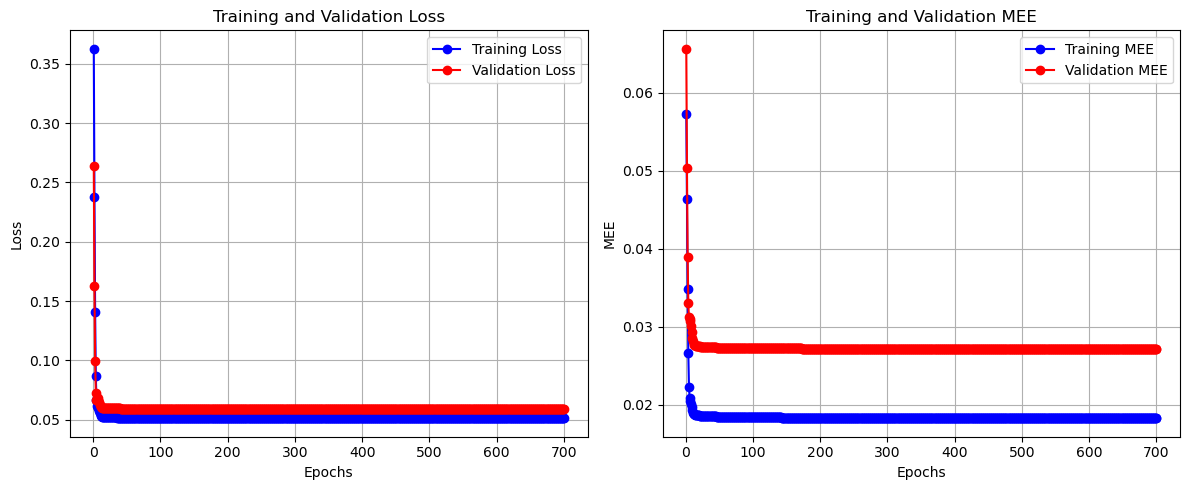

{'learning_rate': 0.03, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.026540379679932884


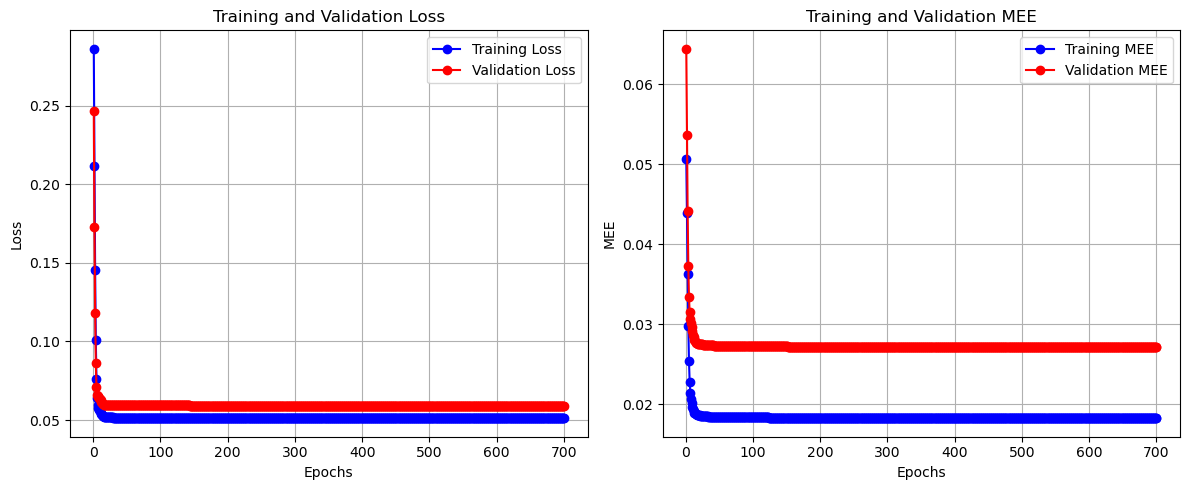

In [67]:
best_scores = [[], [], []]  # Usa una lista di tre elementi per memorizzare i punteggi
best_params_list = [[], [], []]  # Lista di tre elementi per le configurazioni
best_models = [[], [], []]  # Lista di tre elementi per i modelli
best_histories = [[], [], []]  # Lista di tre elementi per la storia di allenamento

# Definisce i parametri della rete neurale
input_size = X_train_scaled.shape[1]
output_size = 3

# Definizione dei range degli iperparametri
param_ranges_1 = {
    "learning_rate": (0.03, 0.03, 0.01),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (700, 700, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (128, 128, 1),             # Da 8 a 32 con step di 8
    "hidden_size": (80, 80, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (2, 2, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.8, 0.8, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.0001, 0.0001, 0.0005),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

#start_time = time.time()
print("Generazione delle combinazioni di iperparametri...")
param_grid_monk1 = []
param_grid_monk1 = generate_hyperparameter_combinations(param_ranges_1)


print("--------------------------------------------------MONK 1--------------------------------------------------")
best_scores[0], best_params_list[0], best_models[0], best_histories[0] = greed_search(X_train_scaled, y_train_scaled, 
                                                                                      'tanh', 'SGD', False, 
                                                                                      input_size, output_size, param_grid_monk1)

print("--------------------------------------------------Plots--------------------------------------------------")
for i, (history, params, score) in enumerate(zip(best_histories[0], best_params_list[0], best_scores[0])):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)